# Real-time Audio Processing Testing Notebook

This notebook demonstrates and tests the audio processing system with faster-whisper integration.

In [6]:
!apt-get update && apt-get install -y portaudio19-dev python3-pyaudio

!brew install portaudio

# Install required packages
!pip install faster-whisper webrtcvad numpy websockets torch matplotlib sounddevice scipy pyaudio

zsh:1: command not found: apt-get
To reinstall 19.7.0, run:
  brew reinstall portaudio


In [4]:
!pip install gtts pydub

  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)


In [15]:
import base64
import numpy as np
from collections import deque
from typing import Optional, List, Dict
import webrtcvad
import wave
import json
from gtts import gTTS
import torch
from faster_whisper import WhisperModel
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import asyncio
import websockets
import queue
import threading
import time
from gtts import gTTS
from pydub import AudioSegment
import io

## 1. Test Audio Recording

In [16]:
test_script = "                                   Technology is evolving rapidly, shaping the way we communicate, learn, and entertain ourselves. Every day, new innovations make it easier to stay connected, access vast information, and engage with diverse cultures from around the globe. Artificial intelligence, for instance, has revolutionized industries by enhancing automation, predictive capabilities, and personalization. Yet, as these advancements continue, they raise ethical and social considerations about privacy, equity, and the future of work. In this era of digital transformation, finding a balance between progress and responsibility remains essential."

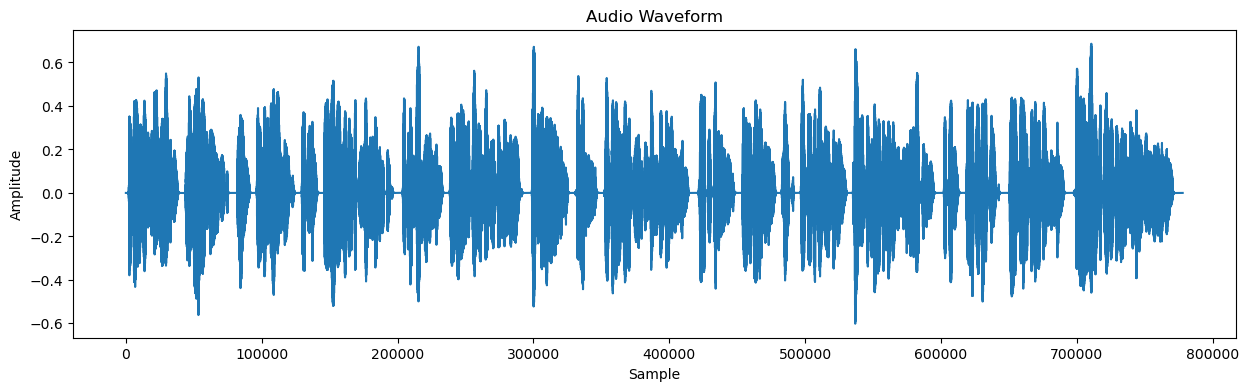

In [17]:
def create_text_audio_data(text="i wanted to know about"):
    """
    Generate audio data for the given text and return it as a NumPy array.
    """
    # Generate TTS audio and save it in-memory
    tts = gTTS(text=text, lang='en')
    audio_io = io.BytesIO()
    tts.write_to_fp(audio_io)
    audio_io.seek(0)

    # Load audio data using pydub and convert to an array
    audio = AudioSegment.from_file(audio_io, format="mp3")
    audio = audio.set_channels(1).set_frame_rate(16000)  # Convert to mono and standard sample rate

    # Convert audio data to NumPy array
    audio_data = np.array(audio.get_array_of_samples()).astype(np.float32) / 32768.0  # Normalize

    return audio_data


def load_wav_file(filename):
    """
    Load a WAV file and return the audio data.
    """
    with wave.open(filename, 'rb') as wf:
        audio_data = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int32)
        audio_data = audio_data.astype(np.float32) / 32767
    return audio_data

test_audio = create_text_audio_data(test_script)
plt.figure(figsize=(15, 4))
plt.plot(test_audio)
plt.title('Audio Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

display(Audio(test_audio, rate=16000))

## 2. Test VAD (Voice Activity Detection)

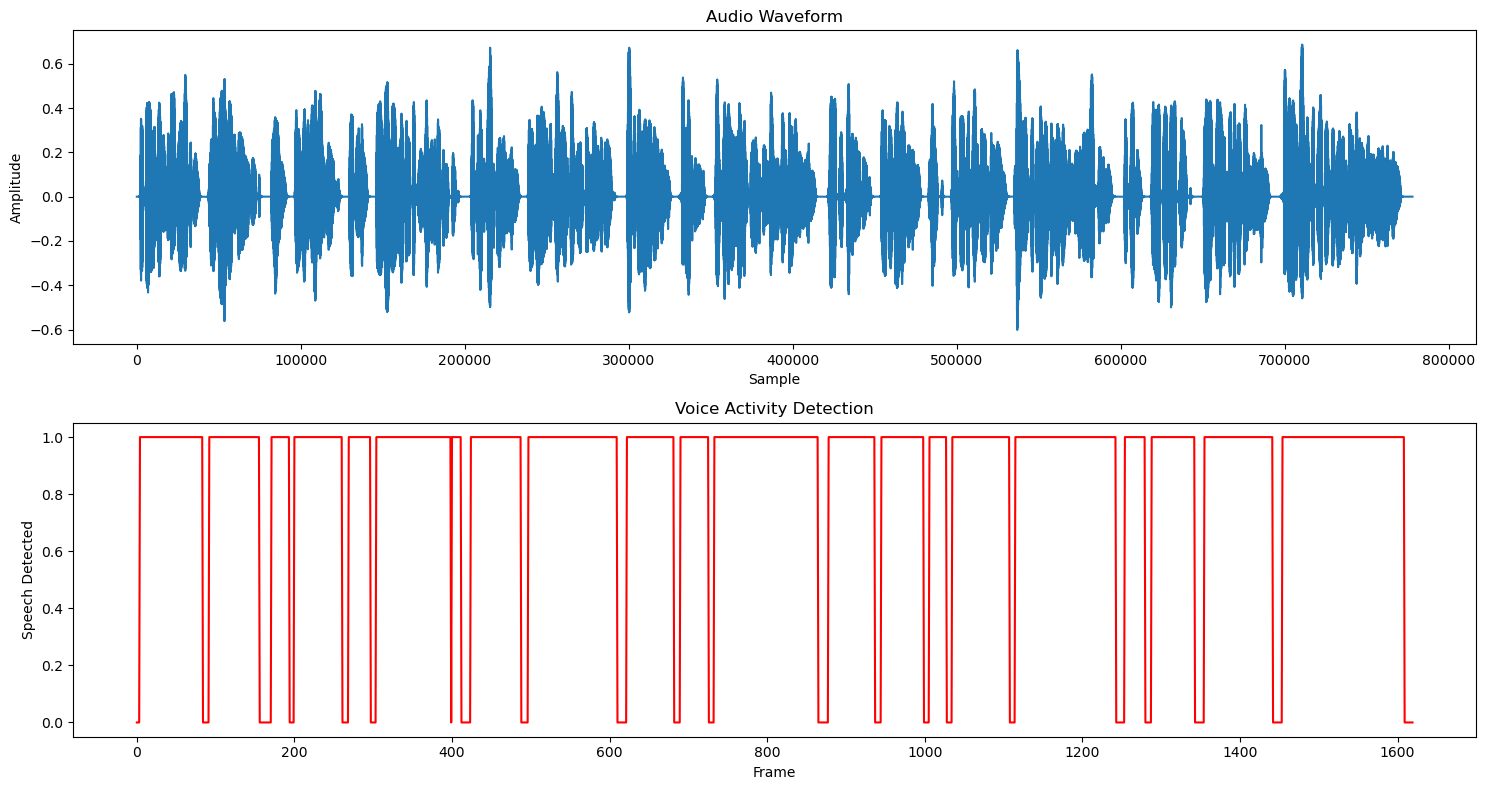

In [18]:
def test_vad(audio_data, sample_rate=16000, frame_duration=30):
    """
    Test Voice Activity Detection on audio data.
    """
    vad = webrtcvad.Vad(3)
    frame_length = int(sample_rate * (frame_duration / 1000.0))
    frames = []
    speech_frames = []

    for i in range(0, len(audio_data) - frame_length, frame_length):
        frame = audio_data[i:i + frame_length]
        frame_bytes = (frame * 32767).astype(np.int16).tobytes()
        frames.append(frame)
        speech_frames.append(vad.is_speech(frame_bytes, sample_rate))

    return frames, speech_frames

# Test VAD
frames, speech_frames = test_vad(test_audio)

# Visualize VAD results
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(test_audio)
plt.title('Audio Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(speech_frames, 'r')
plt.title('Voice Activity Detection')
plt.xlabel('Frame')
plt.ylabel('Speech Detected')

plt.tight_layout()
plt.show()

In [43]:
import numpy as np
from pydub import AudioSegment
import io
from typing import Union, Optional, Tuple
import warnings

class AudioFormatError(Exception):
    """Custom exception for audio format-related errors."""
    pass

def validate_audio_data(audio_data: np.ndarray) -> None:
    """
    Validate the input audio data array.
    
    Parameters:
    - audio_data: NumPy array of audio samples
    
    Raises:
    - TypeError: If input is not a NumPy array
    - ValueError: If array is empty or contains invalid values
    """
    if not isinstance(audio_data, np.ndarray):
        raise TypeError("Audio data must be a NumPy array")
    
    if audio_data.size == 0:
        raise ValueError("Audio data array is empty")
    
    if not np.issubdtype(audio_data.dtype, np.number):
        raise ValueError("Audio data must contain numeric values")
    
    if np.any(np.abs(audio_data) > 1.0):
        warnings.warn("Audio data contains values outside the normalized range [-1, 1]")

def get_supported_formats() -> list:
    """
    Return a list of supported audio formats.
    
    Returns:
    - List of supported format strings
    """
    return ['mp3', 'wav', 'ogg', 'flac']

def audio_data_to_file(
    audio_data: np.ndarray,
    output_format: str = "mp3",
    sample_rate: int = 16000,
    sample_width: int = 2,
    channels: int = 1,
    normalize: bool = True
) -> Union[io.BytesIO, None]:
    """
    Convert NumPy array audio data to a playable audio format with enhanced error handling
    and flexibility.
    
    Parameters:
    - audio_data: The NumPy array of audio samples (expected range: [-1, 1])
    - output_format: The desired output format (e.g., 'mp3', 'wav', 'ogg', 'flac')
    - sample_rate: The sample rate in Hz (default: 16000)
    - sample_width: The sample width in bytes (default: 2 for 16-bit audio)
    - channels: Number of audio channels (default: 1 for mono)
    - normalize: Whether to normalize the audio data if it's not already (default: True)
    
    Returns:
    - BytesIO object containing the audio data in the desired format
    
    Raises:
    - AudioFormatError: If the specified format is not supported
    - ValueError: If audio parameters are invalid
    - TypeError: If input types are incorrect
    """
    try:
        # Validate input parameters
        validate_audio_data(audio_data)
        
        if output_format.lower() not in get_supported_formats():
            raise AudioFormatError(f"Unsupported format: {output_format}. "
                                 f"Supported formats: {get_supported_formats()}")
        
        if sample_rate <= 0:
            raise ValueError("Sample rate must be positive")
        
        if sample_width not in [1, 2, 3, 4]:
            raise ValueError("Sample width must be between 1 and 4 bytes")
        
        if channels <= 0:
            raise ValueError("Number of channels must be positive")
        
        # Work with a copy of the data to avoid modifying the original
        audio_data_copy = audio_data.copy()
        
        # Normalize if requested and not already normalized
        if normalize:
            max_val = np.max(np.abs(audio_data_copy))
            if max_val > 1.0:
                audio_data_copy = audio_data_copy / max_val
        
        # Convert to integer values based on sample width
        max_value = 2 ** (sample_width * 8 - 1) - 1
        int_audio_data = (audio_data_copy * max_value).astype(
            {1: np.int8, 2: np.int16, 3: np.int32, 4: np.int32}[sample_width]
        )
        
        # Create an AudioSegment from raw audio data
        audio_segment = AudioSegment(
            data=int_audio_data.tobytes(),
            sample_width=sample_width,
            frame_rate=sample_rate,
            channels=channels
        )
        
        # Save the AudioSegment to a BytesIO object
        audio_bytes = io.BytesIO()
        audio_segment.export(audio_bytes, format=output_format.lower())
        audio_bytes.seek(0)
        
        return audio_bytes
        
    except Exception as e:
        # Re-raise known exceptions, wrap unknown ones
        if isinstance(e, (AudioFormatError, ValueError, TypeError)):
            raise
        raise RuntimeError(f"Error converting audio data: {str(e)}") from e

def get_audio_info(audio_bytes: io.BytesIO, format: str) -> dict:
    """
    Get information about the audio data in the BytesIO object.
    
    Parameters:
    - audio_bytes: BytesIO object containing audio data
    - format: Format of the audio data
    
    Returns:
    - Dictionary containing audio information
    """
    audio_segment = AudioSegment.from_file(audio_bytes, format=format)
    return {
        'duration_seconds': len(audio_segment) / 1000,
        'frame_rate': audio_segment.frame_rate,
        'channels': audio_segment.channels,
        'sample_width': audio_segment.sample_width,
        'frame_count': len(audio_segment.raw_data) // (audio_segment.sample_width * audio_segment.channels)
    }

def file_to_audio_data(
    audio_bytes: Union[io.BytesIO, bytes, str],
    format: Optional[str] = 'mp3',
    normalize: bool = True
) -> Tuple[np.ndarray, dict]:
    """
    Convert audio file data back to a NumPy array.
    
    Parameters:
    - audio_bytes: Either a BytesIO object, bytes object, or path to audio file
    - format: Audio format (optional, required if input is BytesIO or bytes)
    - normalize: Whether to normalize the output to [-1, 1] range (default: True)
    
    Returns:
    - Tuple containing:
        - NumPy array of audio samples
        - Dictionary with audio metadata (sample rate, channels, etc.)
    
    Raises:
    - ValueError: If input format is not specified for BytesIO/bytes input
    - AudioFormatError: If audio format is not supported
    """
    try:
        # Handle different input types
        if isinstance(audio_bytes, str):
            # Input is a file path
            audio_segment = AudioSegment.from_file(audio_bytes)
        elif isinstance(audio_bytes, (io.BytesIO, bytes)):
            # Input is bytes or BytesIO
            if format is None:
                raise ValueError("Format must be specified when input is bytes or BytesIO")
            if format.lower() not in get_supported_formats():
                raise AudioFormatError(f"Unsupported format: {format}")
            
            if isinstance(audio_bytes, bytes):
                audio_bytes = io.BytesIO(audio_bytes)
            
            audio_bytes.seek(0)
            audio_segment = AudioSegment.from_file(audio_bytes, format=format)
        else:
            raise TypeError("Input must be BytesIO, bytes, or file path")

        # Get audio info
        info = {
            'sample_rate': audio_segment.frame_rate,
            'channels': audio_segment.channels,
            'sample_width': audio_segment.sample_width,
            'duration_seconds': len(audio_segment) / 1000
        }
        
        # Convert to numpy array
        samples = np.array(audio_segment.get_array_of_samples())
        
        # Handle multi-channel audio
        if audio_segment.channels > 1:
            samples = samples.reshape((-1, audio_segment.channels))
        
        # Convert to float and normalize
        dtype_info = np.iinfo(samples.dtype)
        samples = samples.astype(np.float32)
        
        if normalize:
            samples /= max(abs(dtype_info.min), dtype_info.max)
        
        return samples

    except Exception as e:
        # Re-raise known exceptions, wrap unknown ones
        if isinstance(e, (AudioFormatError, ValueError, TypeError)):
            raise
        raise RuntimeError(f"Error decoding audio data: {str(e)}") from e

# Audio Processor Class

In [44]:
import numpy as np
import torch
import webrtcvad
from collections import deque
from typing import Dict, Optional, List, Tuple
from faster_whisper import WhisperModel
import logging
from datetime import datetime

class AudioProcessingError(Exception):
    """Custom exception for audio processing errors."""
    pass

class AudioProcessor:
    def __init__(
        self,
        sample_rate: int = 16000,
        chunk_duration_ms: int = 30,
        padding_duration_ms: int = 300,
        silence_threshold: float = 0.01,
        min_speech_duration_ms: int = 500,
        max_silence_duration_ms: int = 1000,
        model_size: str = "base",
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        compute_type: str = "float16" if torch.cuda.is_available() else "int8",
        max_buffer_size: int = 100,  # Maximum number of chunks to store
        logging_enabled: bool = True
    ):
        """
        Initialize AudioProcessor with enhanced configuration and error handling.
        
        New Parameters:
        - max_buffer_size: Maximum number of audio chunks to store
        - logging_enabled: Whether to enable logging
        """
        # Validate initialization parameters
        self._validate_init_params(
            sample_rate, chunk_duration_ms, padding_duration_ms,
            silence_threshold, min_speech_duration_ms, max_silence_duration_ms
        )
        
        self.sample_rate = sample_rate
        self.chunk_duration_ms = chunk_duration_ms
        self.padding_duration_ms = padding_duration_ms
        self.silence_threshold = silence_threshold
        self.min_speech_duration_ms = min_speech_duration_ms
        self.max_silence_duration_ms = max_silence_duration_ms
        self.max_buffer_size = max_buffer_size
        
        # Setup logging
        self.logger = self._setup_logging() if logging_enabled else None

        try:
            # Initialize VAD with error handling
            self.vad = webrtcvad.Vad(3)
            self._test_vad()
            
            # Initialize Whisper model with error handling
            self.model = self._initialize_whisper_model(model_size, device, compute_type)
        except Exception as e:
            raise AudioProcessingError(f"Failed to initialize audio processor: {str(e)}")

        # Enhanced buffer management
        self.audio_buffer = deque(maxlen=max_buffer_size)
        self.timestamp_buffer = deque(maxlen=max_buffer_size)  # Store timestamps
        self.current_transcript = ""
        self.silence_start = None
        self.is_speaking = False
        self.speaking_duration = 0
        self.partial_transcripts = []
        
        # State management
        self.last_process_time = None
        self.cumulative_silence = 0
        self.speech_segments: List[Tuple[float, float]] = []  # [(start_time, end_time)]

    def _validate_init_params(self, *params):
        """Validate initialization parameters."""
        sample_rate, chunk_duration_ms, padding_duration_ms, \
        silence_threshold, min_speech_duration_ms, max_silence_duration_ms = params
        
        if sample_rate not in [8000, 16000, 32000, 48000]:
            raise ValueError(f"Invalid sample rate: {sample_rate}")
        if chunk_duration_ms < 10 or chunk_duration_ms > 500:
            raise ValueError(f"Invalid chunk duration: {chunk_duration_ms}")
        if silence_threshold < 0 or silence_threshold > 1:
            raise ValueError(f"Invalid silence threshold: {silence_threshold}")

    def _setup_logging(self) -> logging.Logger:
        """Setup logging configuration."""
        logger = logging.getLogger('AudioProcessor')
        logger.setLevel(logging.INFO)
        
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
            )
            handler.setFormatter(formatter)
            logger.addHandler(handler)
        
        return logger

    def _test_vad(self):
        """Test VAD functionality with sample data."""
        test_audio = np.zeros(int(self.sample_rate * 0.03), dtype=np.int16)
        try:
            self.vad.is_speech(test_audio.tobytes(), self.sample_rate)
        except Exception as e:
            raise AudioProcessingError(f"VAD test failed: {str(e)}")

    def _initialize_whisper_model(
        self, model_size: str, device: str, compute_type: str
    ) -> WhisperModel:
        """Initialize and test Whisper model."""
        try:
            return WhisperModel(
                model_size_or_path=model_size,
                device=device,
                compute_type=compute_type,
                download_root=None  # Use default path
            )
        except Exception as e:
            raise AudioProcessingError(f"Failed to initialize Whisper model: {str(e)}")

    def _is_silence(self, audio_chunk: np.ndarray) -> bool:
        """
        Enhanced silence detection with multiple criteria.
        """
        if audio_chunk.size == 0:
            return True
            
        rms = np.sqrt(np.mean(np.square(audio_chunk)))
        peak = np.max(np.abs(audio_chunk))
        zero_crossings = np.sum(np.abs(np.diff(np.signbit(audio_chunk))))
        
        return (
            rms < self.silence_threshold and
            peak < self.silence_threshold * 2 and
            zero_crossings < len(audio_chunk) * 0.1
        )

    def process_audio_chunk(self, event_data: Dict) -> Optional[Dict]:
        """
        Process incoming audio chunk with enhanced error handling and monitoring.
        """
        try:
            current_time = datetime.now()
            
            # Input validation
            if not isinstance(event_data, dict) or "audio" not in event_data:
                raise ValueError("Invalid event data format")
            
            # Process audio data
            audio_data = file_to_audio_data(event_data["audio"])
            if audio_data.size == 0:
                return None
                
            # Store audio with timestamp
            self.audio_buffer.append(audio_data)
            self.timestamp_buffer.append(current_time)
            
            # Update processing time
            if self.last_process_time:
                time_diff = (current_time - self.last_process_time).total_seconds() * 1000
                if time_diff > self.chunk_duration_ms * 1.5:
                    self.logger.warning(f"Processing delay detected: {time_diff}ms")
            
            self.last_process_time = current_time

            # Enhanced voice activity detection
            is_speech = self._detect_voice_activity(audio_data)
            
            return self._update_speech_state(is_speech)
            
        except Exception as e:
            if self.logger:
                self.logger.error(f"Error processing audio chunk: {str(e)}")
            return None

    def _detect_voice_activity(self, audio_data: np.ndarray) -> bool:
        """
        Enhanced voice activity detection combining VAD and energy-based detection.
        """
        try:
            # VAD detection
            vad_result = self.vad.is_speech(
                audio_data.tobytes(),
                sample_rate=self.sample_rate
            )
            
            # Energy-based detection
            energy_result = not self._is_silence(audio_data)
            
            # Combine results (can be tuned based on requirements)
            return vad_result or energy_result
            
        except Exception as e:
            if self.logger:
                self.logger.warning(f"VAD detection failed, falling back to energy-based: {str(e)}")
            return not self._is_silence(audio_data)

    def _update_speech_state(self, is_speech: bool) -> Optional[Dict]:
        """
        Update speech state and handle transitions with improved logic.
        """
        if is_speech:
            if not self.is_speaking:
                self.is_speaking = True
                self.silence_start = None
                self.speaking_duration = 0
                if self.logger:
                    self.logger.debug("Speech started")
            
            self.speaking_duration += self.chunk_duration_ms
            self.cumulative_silence = 0
            
        else:  # Silence detected
            if self.is_speaking:
                if self.silence_start is None:
                    self.silence_start = datetime.now()
                    if self.logger:
                        self.logger.debug("Silence started")
                
                self.cumulative_silence += self.chunk_duration_ms
                
                # Check if silence duration exceeds threshold
                if self.cumulative_silence >= self.max_silence_duration_ms:
                    if self.speaking_duration >= self.min_speech_duration_ms:
                        return self._process_completed_utterance()
                    else:
                        self._reset_state()
                        if self.logger:
                            self.logger.debug("Speech duration too short, discarding")

        # Update partial transcripts periodically
        if len(self.audio_buffer) * self.chunk_duration_ms >= 500:
            self._update_partial_transcript()
            
        return None

    def _update_partial_transcript(self):
        """
        Update partial transcription with improved error handling and context.
        """
        if not self.audio_buffer:
            return

        try:
            audio = np.concatenate(list(self.audio_buffer))
            segments, _ = self.model.transcribe(
                audio,
                beam_size=5,
                word_timestamps=True,
                condition_on_previous_text=bool(self.partial_transcripts),
                initial_prompt=self.partial_transcripts[-1] if self.partial_transcripts else None
            )

            transcript = " ".join(segment.text for segment in segments)
            if transcript.strip():
                self.partial_transcripts.append(transcript)
                if self.logger:
                    self.logger.debug(f"Partial transcript: {transcript}")

        except Exception as e:
            if self.logger:
                self.logger.error(f"Error updating partial transcript: {str(e)}")

    def _process_completed_utterance(self) -> Optional[Dict]:
        """
        Process completed utterance with enhanced error handling and analysis.
        """
        try:
            if not self.audio_buffer:
                return None

            # Combine audio chunks with proper handling of padding
            full_audio = np.concatenate(list(self.audio_buffer))
            
            # Add padding silence if needed
            if self.padding_duration_ms > 0:
                padding_samples = int(self.sample_rate * self.padding_duration_ms / 1000)
                full_audio = np.pad(full_audio, (padding_samples, padding_samples))

            # Transcribe with enhanced parameters
            segments, info = self.model.transcribe(
                full_audio,
                beam_size=5,
                word_timestamps=True,
                condition_on_previous_text=bool(self.partial_transcripts),
                initial_prompt=self.partial_transcripts[-1] if self.partial_transcripts else None,
                vad_filter=True,
                vad_parameters=dict(
                    min_silence_duration_ms=self.max_silence_duration_ms / 2
                )
            )

            transcription = " ".join(segment.text for segment in segments)
            
            # Enhanced response decision
            should_respond = self._should_respond(transcription)
            
            if should_respond:
                response = {
                    "should_respond": True,
                    "transcript": transcription,
                    "language": info.language,
                    "language_probability": info.language_probability,
                    "speaking_duration_ms": self.speaking_duration,
                    "confidence": getattr(info, 'confidence', None),
                    "timestamp": datetime.now().isoformat()
                }
            else:
                response = None

            # Reset state
            self._reset_state()
            
            return response

        except Exception as e:
            if self.logger:
                self.logger.error(f"Error processing completed utterance: {str(e)}")
            self._reset_state()
            return None

    def _reset_state(self):
        """Reset all state variables."""
        self.audio_buffer.clear()
        self.timestamp_buffer.clear()
        self.is_speaking = False
        self.silence_start = None
        self.speaking_duration = 0
        self.cumulative_silence = 0
        self.partial_transcripts = []
        self.current_transcript = ""

    def _should_respond(self, transcript: str) -> bool:
        """
        Enhanced response detection with improved heuristics.
        """
        if not transcript.strip():
            return False

        transcript_lower = transcript.lower()
        
        # Question detection
        question_indicators = {
            "direct": ["?", "what", "how", "when", "where", "why", "who"],
            "indirect": ["can you", "could you", "would you", "will you"],
            "clarification": ["right", "correct", "isn't it", "don't you"]
        }
        
        # Command detection
        command_indicators = {
            "direct": ["please", "help", "tell me", "show me", "explain"],
            "action": ["do", "make", "create", "find", "search"],
            "system": ["start", "stop", "pause", "continue"]
        }

        # Check for questions
        for indicators in question_indicators.values():
            if any(indicator in transcript_lower for indicator in indicators):
                return True

        # Check for commands
        for indicators in command_indicators.values():
            if any(indicator in transcript_lower for indicator in indicators):
                return True

        # Check for complete thoughts
        sentence_endings = (".", "!", "?")
        if any(transcript.strip().endswith(end) for end in sentence_endings):
            return True

        # Check for meaningful content length
        words = transcript.split()
        if len(words) >= 5:  # Arbitrary threshold for meaningful content
            return True

        return False

## 3. Test Faster Whisper Transcription

In [45]:
import torch
print("Is Cuda available {}".format(torch.cuda.is_available()))

Is Cuda available False


In [46]:
def test_transcription(audio_data, sample_rate=16000):
    """
    Test faster-whisper transcription.
    """
    # Initialize model
    model = WhisperModel(
        model_size_or_path='base',
        device="cuda" if torch.cuda.is_available() else "cpu",
        compute_type="float16" if torch.cuda.is_available() else "int8"
    )

    # Transcribe
    segments, info = model.transcribe(
        audio_data,
        beam_size=5,
        word_timestamps=True,
        vad_filter=True,
        vad_parameters=dict(min_silence_duration_ms=500),
    )

    return segments, info

# Test transcription
segments, info = test_transcription(test_audio)

print("Transcription Results:")
print(f"Detected language: {info.language} (probability: {info.language_probability:.2f})\n")

for segment in segments:
    print(f"[{segment.start:.1f}s -> {segment.end:.1f}s] {segment.text}")

Transcription Results:
Detected language: en (probability: 0.96)

[0.0s -> 7.4s]  Technology is evolving rapidly, shaping the way we communicate, learn, and entertain ourselves.
[8.1s -> 14.4s]  Every day, new innovations make it easier to stay connected, access vast information,
[14.9s -> 21.4s]  and engage with diverse cultures from around the globe. Artificial intelligence, for instance,
[21.9s -> 27.5s]  has revolutionized industries by enhancing automation, predictive capabilities,
[27.5s -> 35.1s]  and personalization, yet, as these advancements continue, they raise ethical and social
[35.1s -> 42.9s]  considerations about privacy, equity, and the future of work. In this era of digital transformation,
[42.9s -> 48.0s]  finding a balance between progress and responsibility remains essential.


Numpy audio data back to audio 

## 4. Test Complete Pipeline

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from datetime import datetime
import json
from pathlib import Path
import pandas as pd
from tqdm import tqdm

class AudioProcessorTester:
    def __init__(self, save_results: bool = True, output_dir: str = "test_results"):
        """
        Initialize the tester with configuration options.
        
        Parameters:
        - save_results: Whether to save test results to files
        - output_dir: Directory to save test results
        """
        self.save_results = save_results
        self.output_dir = Path(output_dir)
        if save_results:
            self.output_dir.mkdir(exist_ok=True)
        
        self.test_metrics = {
            'total_chunks': 0,
            'processed_chunks': 0,
            'detected_utterances': 0,
            'processing_times': [],
            'chunk_sizes': [],
            'transcription_lengths': [],
            'language_probabilities': []
        }

    def test_complete_pipeline(
        self,
        audio_data: np.ndarray,
        chunk_size_ms: int = 30,
        sample_rate: int = 16000,
        processor_kwargs: Optional[Dict] = None
    ) -> Tuple[List[Dict], Dict]:
        """
        Test the complete audio processing pipeline with detailed metrics and validation.
        
        Parameters:
        - audio_data: Input audio data as numpy array
        - chunk_size_ms: Size of each chunk in milliseconds
        - sample_rate: Audio sample rate
        - processor_kwargs: Additional kwargs for AudioProcessor initialization
        
        Returns:
        - Tuple of (results, metrics)
        """
        try:
            # Initialize processor with custom parameters
            processor_kwargs = processor_kwargs or {}
            processor = AudioProcessor(
                sample_rate=sample_rate,
                chunk_duration_ms=chunk_size_ms,
                **processor_kwargs
            )
            
            # Validate input audio
            self._validate_audio_data(audio_data, sample_rate)
            
            # Split audio into chunks
            chunk_size = int(sample_rate * (chunk_size_ms / 1000.0))
            chunks = self._split_into_chunks(audio_data, chunk_size)
            
            # Process chunks with progress bar
            results = []
            timings = []
            
            with tqdm(total=len(chunks), desc="Processing audio chunks") as pbar:
                for i, chunk in enumerate(chunks):
                    # Time the processing
                    start_time = datetime.now()
                    
                    # Create event data
                    event_data = self._create_event_data(chunk, i)
                    
                    # Process chunk
                    result = processor.process_audio_chunk(event_data)
                    
                    # Record timing
                    processing_time = (datetime.now() - start_time).total_seconds() * 1000
                    timings.append(processing_time)
                    
                    # Update metrics
                    self._update_metrics(chunk, result, processing_time)
                    
                    # Store result
                    if result:
                        results.append(self._enrich_result(result, i, processing_time))
                    
                    pbar.update(1)
            
            # Calculate final metrics
            final_metrics = self._calculate_final_metrics()
            
            # Save results if enabled
            if self.save_results:
                self._save_test_results(results, final_metrics)
                self._generate_visualizations(results, timings)
            
            return results, final_metrics
            
        except Exception as e:
            raise RuntimeError(f"Pipeline test failed: {str(e)}")

    def _validate_audio_data(self, audio_data: np.ndarray, sample_rate: int):
        """Validate input audio data."""
        if not isinstance(audio_data, np.ndarray):
            raise ValueError("Audio data must be a NumPy array")
        
        if audio_data.size == 0:
            raise ValueError("Audio data is empty")
        
        expected_duration = len(audio_data) / sample_rate
        if expected_duration < 0.1:  # Arbitrary minimum duration
            raise ValueError(f"Audio too short: {expected_duration:.2f} seconds")

    def _split_into_chunks(
        self, audio_data: np.ndarray, chunk_size: int
    ) -> List[np.ndarray]:
        """Split audio data into chunks with proper handling of remainder."""
        chunks = []
        for i in range(0, len(audio_data), chunk_size):
            chunk = audio_data[i:i + chunk_size]
            # Pad last chunk if necessary
            if len(chunk) < chunk_size:
                chunk = np.pad(
                    chunk,
                    (0, chunk_size - len(chunk)),
                    mode='constant'
                )
            chunks.append(chunk)
        return chunks

    def _create_event_data(self, chunk: np.ndarray, index: int) -> Dict:
        """Create event data for chunk processing."""
        return {
            "event_id": f"event_{index}",
            "type": "input_audio_buffer.append",
            "timestamp": datetime.now().isoformat(),
            "audio": audio_data_to_file(chunk),
            "chunk_index": index
        }

    def _update_metrics(
        self,
        chunk: np.ndarray,
        result: Optional[Dict],
        processing_time: float
    ):
        """Update test metrics with chunk processing results."""
        self.test_metrics['total_chunks'] += 1
        self.test_metrics['processed_chunks'] += 1 if result else 0
        self.test_metrics['detected_utterances'] += 1 if result and result.get('should_respond') else 0
        self.test_metrics['processing_times'].append(processing_time)
        self.test_metrics['chunk_sizes'].append(len(chunk))
        
        if result:
            self.test_metrics['transcription_lengths'].append(
                len(result['transcript'].split())
            )
            self.test_metrics['language_probabilities'].append(
                result['language_probability']
            )

    def _enrich_result(self, result: Dict, chunk_index: int, processing_time: float) -> Dict:
        """Enrich result with additional metadata."""
        return {
            **result,
            "chunk_index": chunk_index,
            "processing_time_ms": processing_time,
            "timestamp": datetime.now().isoformat()
        }

    def _calculate_final_metrics(self) -> Dict:
        """Calculate final metrics from collected data."""
        processing_times = np.array(self.test_metrics['processing_times'])
        
        metrics = {
            "total_chunks_processed": self.test_metrics['total_chunks'],
            "utterances_detected": self.test_metrics['detected_utterances'],
            "detection_rate": self.test_metrics['detected_utterances'] / self.test_metrics['total_chunks'],
            "processing_time_stats": {
                "mean_ms": np.mean(processing_times),
                "std_ms": np.std(processing_times),
                "min_ms": np.min(processing_times),
                "max_ms": np.max(processing_times),
                "p95_ms": np.percentile(processing_times, 95)
            }
        }
        
        if self.test_metrics['transcription_lengths']:
            metrics["transcription_stats"] = {
                "mean_words": np.mean(self.test_metrics['transcription_lengths']),
                "max_words": np.max(self.test_metrics['transcription_lengths']),
                "total_words": sum(self.test_metrics['transcription_lengths'])
            }
        
        return metrics

    def _save_test_results(self, results: List[Dict], metrics: Dict):
        """Save test results and metrics to files."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save results
        results_file = self.output_dir / f"test_results_{timestamp}.json"
        with open(results_file, 'w') as f:
            json.dump({"results": results, "metrics": metrics}, f, indent=2)
        
        # Save metrics to CSV for easy analysis
        metrics_df = pd.DataFrame(results)
        metrics_file = self.output_dir / f"test_metrics_{timestamp}.csv"
        metrics_df.to_csv(metrics_file, index=False)

    def _generate_visualizations(self, results: List[Dict], timings: List[float]):
        """Generate visualizations of test results."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Processing times
        axes[0, 0].plot(timings)
        axes[0, 0].set_title('Processing Times per Chunk')
        axes[0, 0].set_xlabel('Chunk Index')
        axes[0, 0].set_ylabel('Processing Time (ms)')
        
        # Language probabilities
        if results:
            probs = [r['language_probability'] for r in results]
            axes[0, 1].hist(probs, bins=20)
            axes[0, 1].set_title('Language Detection Probabilities')
            axes[0, 1].set_xlabel('Probability')
            axes[0, 1].set_ylabel('Count')
        
        # Transcription lengths
        if results:
            lengths = [len(r['transcript'].split()) for r in results]
            axes[1, 0].hist(lengths, bins=20)
            axes[1, 0].set_title('Transcription Lengths')
            axes[1, 0].set_xlabel('Words')
            axes[1, 0].set_ylabel('Count')
        
        # Response timeline
        if results:
            chunk_indices = [r['chunk_index'] for r in results]
            responses = [1 if r['should_respond'] else 0 for r in results]
            axes[1, 1].scatter(chunk_indices, responses)
            axes[1, 1].set_title('Response Timeline')
            axes[1, 1].set_xlabel('Chunk Index')
            axes[1, 1].set_ylabel('Should Respond')
        
        plt.tight_layout()
        plot_file = self.output_dir / f"test_visualizations_{timestamp}.png"
        plt.savefig(plot_file)
        plt.close()

def test_pipeline(audio_data: np.ndarray, **kwargs):
    """
    Convenience function to test the pipeline with default settings.
    """
    tester = AudioProcessorTester()
    return tester.test_complete_pipeline(audio_data, **kwargs)

# Run pipeline test
results, metrics = test_pipeline(
    test_audio,
    chunk_size_ms=30,
    processor_kwargs={
        'silence_threshold': 0.01,
        'min_speech_duration_ms': 500
    }
)

# Print results
print("\nTest Results Summary:")
print(f"Total chunks processed: {metrics['total_chunks_processed']}")
print(f"Utterances detected: {metrics['utterances_detected']}")
print(f"Detection rate: {metrics['detection_rate']:.2%}")
print("\nProcessing Time Statistics:")
for key, value in metrics['processing_time_stats'].items():
    print(f"{key}: {value:.2f}ms")

# Individual results are available in the results list
for result in results:
    print(f"\nTranscript: {result['transcript']}")
    print(f"Language: {result['language']} (prob: {result['language_probability']:.2f})")
    print(f"Processing time: {result['processing_time_ms']:.2f}ms")

Processing audio chunks:   0%|                                                              | 0/1621 [00:00<?, ?it/s]


RuntimeError: Pipeline test failed: Error while processing frame

In [ ]:
from transformers import pipeline

# Load a small model for question or response classification
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

def should_respond(text):
    """
    Determine if the model should respond based on the input text.
    Uses a small NLP model to classify if it's a response-worthy phrase.
    """
    response_keywords = ["hello", "help", "can you", "please", "how are", "question"]
    
    # Check if any keywords are present
    if any(keyword in text.lower() for keyword in response_keywords):
        return True
    
    # Use the classifier to see if the input resembles a question or request
    prediction = classifier(text)[0]
    
    # Consider labels like "POSITIVE" as response-worthy
    if prediction["label"] == "POSITIVE" and prediction["score"] > 0.8:
        return True
    else:
        return False

# Test with some example input
input_text = "Hello, can you help me?"
print(f"Should respond: {should_respond(input_text)}")

## 5. Simulate WebSocket Connection

In [ ]:
async def simulate_websocket_stream(audio_data, chunk_size_ms=30):
    """
    Simulate streaming audio over WebSocket.
    """
    chunk_size = int(16000 * (chunk_size_ms / 1000.0))
    chunks = [audio_data[i:i + chunk_size] for i in range(0, len(audio_data), chunk_size)]

    session = AudioChatSession()

    class MockWebSocket:
        async def send(self, message):
            print(f"Received response: {message}")

    mock_ws = MockWebSocket()

    for i, chunk in enumerate(chunks):
        event_data = {
            "event_id": f"event_{i}",
            "type": "input_audio_buffer.append",
            "audio": encode_audio(chunk)
        }

        await session.handle_audio_message(mock_ws, event_data)
        await asyncio.sleep(chunk_size_ms / 1000.0)  # Simulate real-time

# Test WebSocket simulation
await simulate_websocket_stream(test_audio)

## 6. Performance Metrics

In [ ]:
def measure_performance(audio_data, num_runs=5):
    """
    Measure performance metrics of the system.
    """
    processor = AudioProcessor()

    timings = {
        'vad': [],
        'transcription': [],
        'total': []
    }

    for _ in range(num_runs):
        start_total = time.time()

        # Test VAD
        start = time.time()
        frames, speech_frames = test_vad(audio_data)
        timings['vad'].append(time.time() - start)

        # Test transcription
        start = time.time()
        segments, info = test_transcription(audio_data)
        timings['transcription'].append(time.time() - start)

        timings['total'].append(time.time() - start_total)

    print("Performance Metrics (averaged over {num_runs} runs):")
    for key, values in timings.items():
        avg_time = sum(values) / len(values)
        print(f"{key.capitalize()} processing time: {avg_time:.3f}s")

# Measure performance
measure_performance(test_audio)